In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.python.client import device_lib
import numpy as np
import matplotlib.pyplot as plt
import os

# == see if it helps run
num_train = 21142
batch_size = 4
steps_per_epoch = (num_train + batch_size - 1) // batch_size  # 5286

# === Step 0A: Make GPU allocation behave (place this RIGHT AFTER importing TF) ===
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# === Step 0B: tf.data options to avoid thread/memory explosions ===
AUTOTUNE = tf.data.AUTOTUNE
opts = tf.data.Options()
opts.threading.private_threadpool_size = 4
opts.threading.max_intra_op_parallelism = 1

# === Step 0C: (optional) helper for dataset sizes ===
def ds_size(ds):
    c = tf.data.experimental.cardinality(ds)
    return int(c.numpy()) if c >= 0 else None

2025-07-31 18:07:59.896940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753978079.917032    6063 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753978079.922983    6063 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753978079.938076    6063 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753978079.938103    6063 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753978079.938105    6063 computation_placer.cc:177] computation placer alr

In [2]:
# === Step 1: Load dataset (RAW) ===
train_raw = image_dataset_from_directory(
    "../dataset/",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=4
)

val_raw = image_dataset_from_directory(
    "../dataset/",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=4
)

# (Safe to print devices now)
print(device_lib.list_local_devices())

class_names = train_raw.class_names
print("Class names:", class_names)
swee_index = class_names.index("Swee Waxbill")

Found 26427 files belonging to 5 classes.
Using 21142 files for training.


I0000 00:00:1753978084.752627    6063 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2554 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 26427 files belonging to 5 classes.
Using 5285 files for validation.
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10234656368517129963
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2678390784
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17189495625109793549
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]
Class names: ['Cape Sparrow', 'Cape White-eye', 'Masked Weaver', 'Squirrel', 'Swee Waxbill']


I0000 00:00:1753978087.308816    6063 gpu_device.cc:2019] Created device /device:GPU:0 with 2554 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [3]:
# === Step 2: Define augmentation and normalization ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])

normalization_layer = tf.keras.layers.Rescaling(1./255)

In [4]:
# === Step 3: Custom preprocessing to apply more augmentation for Swee Waxbill ===
def custom_preprocess(x, y):
    x = normalization_layer(x)
    # Apply heavier augmentation to Swee Waxbill class
    is_swee = tf.equal(y, swee_index)
    x_augmented = data_augmentation(x, training=True)
    x_augmented = tf.where(is_swee[:, tf.newaxis, tf.newaxis, tf.newaxis], 
                           data_augmentation(x_augmented, training=True), 
                           x_augmented)
    return x_augmented, y

In [5]:
# === Step 4: CACHING BEFORE MAP/SHUFFLE + conservative prefetch ===
# Put cache files on a fast local disk; remove old caches if you change the pipeline.
cache_dir = os.path.expanduser("~/tf-cache")
os.makedirs(cache_dir, exist_ok=True)

train_raw = train_raw.cache(os.path.join(cache_dir, "train.tf-data"))
val_raw   = val_raw.cache(os.path.join(cache_dir, "val.tf-data"))

# Now map AFTER cache so we don't cache augmented tensors
train_ds = train_raw.map(custom_preprocess, num_parallel_calls=AUTOTUNE)
val_ds   = val_raw.map(lambda x, y: (normalization_layer(x), y),
                       num_parallel_calls=AUTOTUNE)

# Shuffle with a decent buffer; keep prefetch small at first
shuffle_buf = 1250

train_ds = (train_ds
    .repeat()
            .shuffle(buffer_size=shuffle_buf, reshuffle_each_iteration=True)
            .prefetch(1)                    # start conservative; bump later if stable
            .with_options(opts))

val_ds = (val_ds
          .prefetch(1)
          .with_options(opts))

In [6]:
# === Step 5: Build the model ===
model = models.Sequential([
    layers.Input(shape=(256, 256, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,877 (1.62 MB)

 Trainable params: 422,917 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [7]:
# === Step 6: Calculate class weights ===
# Based on known image counts: 5500 for all, 4427 for Swee Waxbill
image_counts = [5500, 5500, 5500, 5500, 4427]  # Match class_names order
labels = []
for i, count in enumerate(image_counts):
    labels.extend([i] * count)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=np.array(labels)
)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 0.9609818181818182, 1: 0.9609818181818182, 2: 0.9609818181818182, 3: 0.9609818181818182, 4: 1.1939010616670431}


In [8]:

# === Step 7: Fit the model ===
early_stop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

Epoch 1/40


2025-07-31 18:08:21.788932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 416 of 1250
2025-07-31 18:08:41.777340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1247 of 1250
2025-07-31 18:08:41.846236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
I0000 00:00:1753978121.855974    6144 service.cc:152] XLA service 0x740de4077790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753978121.856009    6144 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-07-31 18:08:42.007405: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753978122.582133    6144 cuda_dnn.cc:529] Loaded cuD

   5/5286 ━━━━━━━━━━━━━━━━━━━━ 2:48 32ms/step - accuracy: 0.2750 - loss: 2.1557

I0000 00:00:1753978129.276522    6144 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5286/5286 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3285 - loss: 1.7042

2025-07-31 18:11:41.813078: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.12 = (f32[4,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,3,256,256]{3,2,1,0} %bitcast.769, f32[32,3,3,3]{3,2,1,0} %bitcast.776, f32[32]{0} %bitcast.778), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_1/convolution" source_file="/home/devon/anaconda3/envs/bird-id/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-31 18:11:41.971661: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted pote

5286/5286 ━━━━━━━━━━━━━━━━━━━━ 224s 35ms/step - accuracy: 0.3286 - loss: 1.7042 - val_accuracy: 0.2291 - val_loss: 12.9524
Epoch 2/40
 152/5286 ━━━━━━━━━━━━━━━━━━━━ 2:24 28ms/step - accuracy: 0.4259 - loss: 1.4568

2025-07-31 18:11:59.130849: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.15 = (f32[2,256,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,128,30,30]{3,2,1,0} %bitcast.8935, f32[256,128,3,3]{3,2,1,0} %bitcast.7294, f32[256]{0} %bitcast.8995), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_3_1/convolution" source_file="/home/devon/anaconda3/envs/bird-id/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


5286/5286 ━━━━━━━━━━━━━━━━━━━━ 188s 36ms/step - accuracy: 0.4826 - loss: 1.3235 - val_accuracy: 0.2184 - val_loss: 17.2695
Epoch 3/40
5286/5286 ━━━━━━━━━━━━━━━━━━━━ 187s 35ms/step - accuracy: 0.5748 - loss: 1.1345 - val_accuracy: 0.2850 - val_loss: 11.7173
Epoch 4/40
5286/5286 ━━━━━━━━━━━━━━━━━━━━ 188s 36ms/step - accuracy: 0.6195 - loss: 1.0498 - val_accuracy: 0.4053 - val_loss: 6.3391
Epoch 5/40
5286/5286 ━━━━━━━━━━━━━━━━━━━━ 191s 36ms/step - accuracy: 0.6507 - loss: 0.9781 - val_accuracy: 0.3342 - val_loss: 10.4183
Epoch 6/40
5286/5286 ━━━━━━━━━━━━━━━━━━━━ 197s 37ms/step - accuracy: 0.6652 - loss: 0.9370 - val_accuracy: 0.3873 - val_loss: 4.4040
Epoch 7/40
5286/5286 ━━━━━━━━━━━━━━━━━━━━ 187s 35ms/step - accuracy: 0.6780 - loss: 0.9065 - val_accuracy: 0.3699 - val_loss: 17.5365
Epoch 8/40
5286/5286 ━━━━━━━━━━━━━━━━━━━━ 183s 35ms/step - accuracy: 0.6987 - loss: 0.8572 - val_accuracy: 0.4015 - val_loss: 3.2793
Epoch 9/40
5286/5286 ━━━━━━━━━━━━━━━━━━━━ 184s 35ms/step - accuracy: 0.6939 

In [9]:
# === Step 8: Save model ===
model.save("5_Species_cnn_2025_07_31.keras")

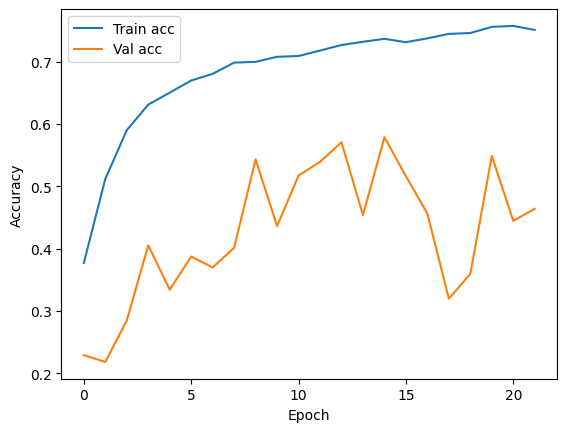

In [10]:
# === Step 9: Plot accuracy ===
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


2025-07-31 19:26:03.287891: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


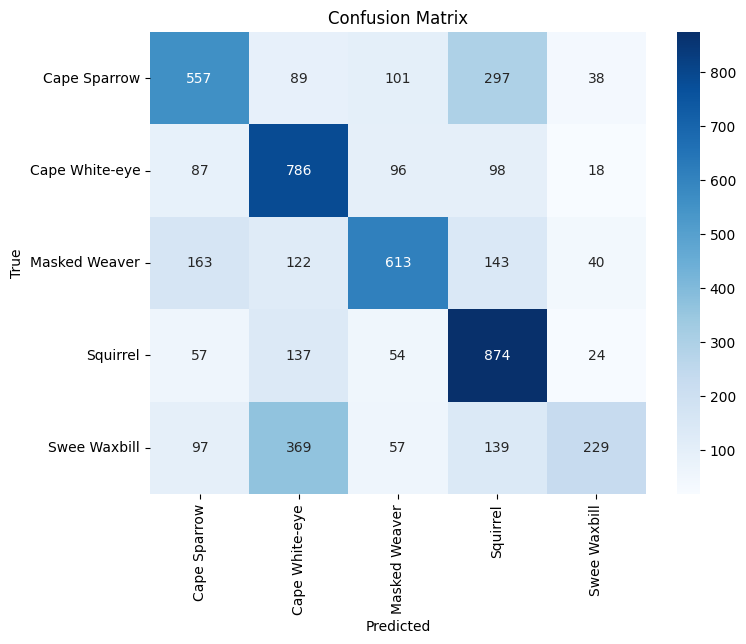

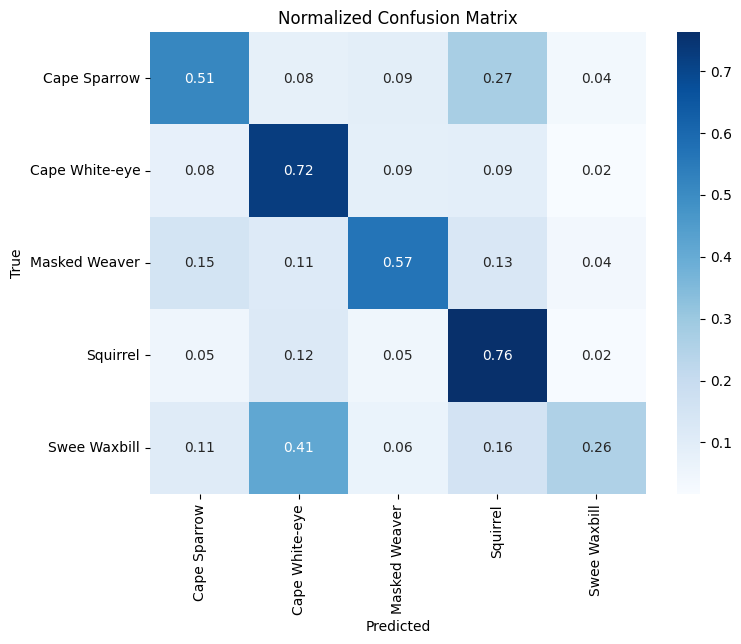

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# === Step 1: Collect predictions and true labels ===
y_true = []
y_pred = []

for images, labels in val_ds.unbatch():
    images = tf.expand_dims(images, axis=0)  # shape: (1, 256, 256, 3)
    preds = model.predict(images, verbose=0)
    y_true.append(int(labels))
    y_pred.append(np.argmax(preds))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# === Step 2: Compute confusion matrix ===
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalized

# === Step 3: Plot raw confusion matrix ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# === Step 4: Plot normalized confusion matrix ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()
